Cell 1 (imports + DB connection)

In [1]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt


project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (base series)

In [2]:
query = """

SELECT

  DATE(order_ts) AS day,

  SUM(net_revenue) AS revenue

FROM orders

GROUP BY day

ORDER BY day;

"""

ts_base = pd.read_sql_query(query, conn)

ts_base["day"] = pd.to_datetime(ts_base["day"])

ts_base = ts_base.set_index("day")

ts_base["returns"] = ts_base["revenue"].pct_change()

ts_base.dropna(inplace=True)

Cell 3 (backtest function)

   - This will let us test many parameter combos cleany.

In [3]:
def backtest_ma(ts, short_w, long_w):

    ts = ts.copy()

    ts["ma_short"] = ts["revenue"].rolling(short_w).mean()

    ts["ma_long"] = ts["revenue"].rolling(long_w).mean()

    ts.dropna(inplace=True)

    ts["signal"] = (ts["ma_short"] > ts["ma_long"]).astype(int)

    ts["position"] = ts["signal"].shift(1)

    ts.dropna(inplace=True)

    ts["strategy_returns"] = ts["position"] * ts["returns"]

    sharpe = ts["strategy_returns"].mean() / ts["strategy_returns"].std()
    
    total_return = (1 + ts["strategy_returns"]).prod() - 1

    return sharpe, total_return

Cell 4 (parameter grid)
 
  - Define a reasonable range

In [4]:
short_windows = range(3, 15)

long_windows = range(10, 50)

results = []

Cell 5 (run sensetivity analysis)

In [5]:
for s in short_windows:

    for l in long_windows:

        if s >= l:

            continue

        sharpe, total_return = backtest_ma(ts_base, s, l)

        results.append({

            "short": s,

            "long": l,

            "sharpe": sharpe,

            "total_return": total_return

        })

results_df = pd.DataFrame(results)

results_df.head()

,short,long,sharpe,total_return
0,3,10,-0.079300,-1.0
1,3,11,-0.078710,-1.0
2,3,12,-0.100370,-1.0
3,3,13,-0.083707,-1.0
4,3,14,-0.069355,-1.0


Cell 6 (visualize sharpe surface)

  - This is where overfitting reveals itself.

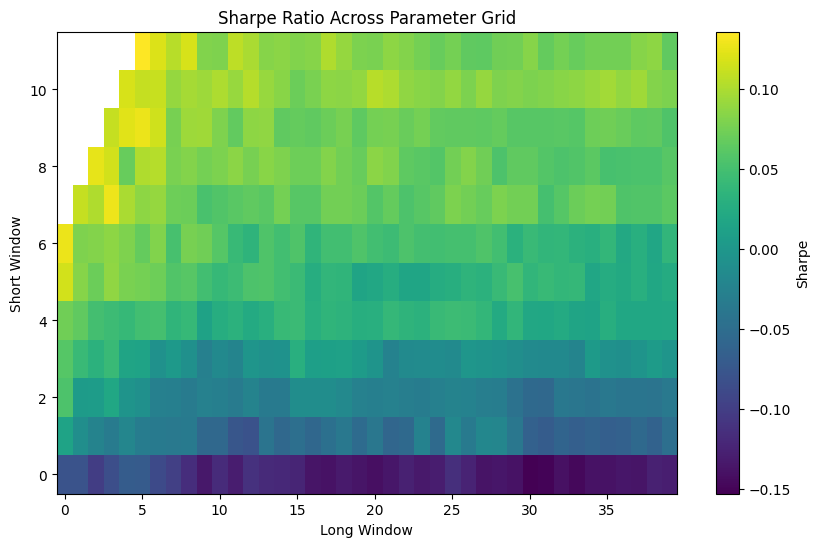

In [6]:
pivot = results_df.pivot(index="short", columns="long", values="sharpe")

plt.figure(figsize=(10,6))

plt.imshow(pivot, aspect="auto", origin="lower")

plt.colorbar(label="Sharpe")

plt.title("Sharpe Ratio Across Parameter Grid")

plt.xlabel("Long Window")

plt.ylabel("Short Window")

plt.show()

How to read this plot:

  - Broad plateau of good values ---> robust strategy
  - Single bright spike ----> overfitting
  - Sharp cliffs ----> unstable

This single chart separates:
   
  - Real edges
  - From noise mining

Cell 7 (best parameters "dont trust them yet)

  - The "best" psrameter is the most suspicious one.

In [7]:
results_df.sort_values("sharpe", ascending=False).head(10)

,short,long,sharpe,total_return
430,14,15,0.136020,-0.974988
282,10,13,0.128147,-0.976549
359,12,15,0.127335,-0.998353
240,9,10,0.127014,-0.999832
319,11,12,0.125378,-0.999931
358,12,14,0.122740,-0.999750
431,14,16,0.120553,-0.999805
433,14,18,0.118860,-0.999987
394,13,14,0.118732,-0.999988
200,8,10,0.116630,-0.999739


Cell 8 (stability check)

  - Check neighboring parameters around best.

In [8]:
best = results_df.sort_values("sharpe", ascending=False).iloc[0]

best

short           14.000000
long            15.000000
sharpe           0.136020
total_return    -0.974988
Name: 430, dtype: float64

Filter nearby:

In [9]:
neighbors = results_df[

    (results_df["short"].between(best["short"] - 1, best["short"] + 1)) &
    
    (results_df["long"].between(best["long"] - 5, best["long"] + 5))

]

neighbors.sort_values("sharpe", ascending=False)

,short,long,sharpe,total_return
430,14,15,0.136020,-0.974988
431,14,16,0.120553,-0.999805
433,14,18,0.118860,-0.999987
394,13,14,0.118732,-0.999988
396,13,16,0.111198,-0.999995
395,13,15,0.110555,-0.999997
432,14,17,0.105184,-0.999998
400,13,20,0.099983,-0.999999
398,13,18,0.097066,-1.000000
399,13,19,0.093625,-1.000000


If performance collapses ---> overfit.

## Day 7 – Parameter Sensitivity & Overfitting

- Strategy performance varies significantly across parameter choices.
- A single optimal parameter set is often misleading.
- Robust strategies exhibit stable performance across a broad region of parameters.
- Sensitivity analysis is essential to avoid overfitting and false confidence.

Backtests must be stress-tested, not optimized.